In [6]:
import glob
import random
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split

In [8]:
images_path = sorted(glob.glob("original photos/*.jpg"))
masks_path = sorted(glob.glob("all masks/*.jpg"))

In [10]:
print(len(images_path))
print(len(masks_path))

142
142


In [12]:
print(images_path[0])
print(masks_path[0])

original photos\B01L1P1.jpg
all masks\B01L1P1.jpg


In [14]:
import cv2

In [58]:
import cv2
import numpy as np

X = []
Y = []

for index, value in enumerate(images_path):
    # Reading the original image
    image = cv2.imread(images_path[index])  # Read image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)  # Resize
    image = image / 255.0  # Normalize
    X.append(image)

    # Reading the corresponding mask
    masks = cv2.imread(masks_path[index])  # Read mask in grayscale
    masks = cv2.cvtColor(masks,cv2.COLOR_BGR2GRAY)
    masks = np.where(masks < 100, 0, 255).astype(np.uint8)
    masks = cv2.resize(masks, (224, 224), interpolation=cv2.INTER_NEAREST)  # Resize
    masks = masks/255 # Normalize to 0-1 range
    masks = masks.astype(np.uint8)  # Convert to uint8
    Y.append(masks)


In [60]:
unique_pixel_values = np.unique(Y[0])
print(unique_pixel_values)

[0 1]


In [62]:
def visualization(X,Y):
    for i,_ in enumerate(X[:10]):
        fig,axes  = plt.subplots(1,2)
        axes[0].imshow(X[i])
        axes[0].set_title("image")
        axes[1].imshow(Y[i],cmap = 'gray')
        axes[1].set_title('Mask')

        for ax in axes:
            ax.axis('off')

        plt.tight_layout()

        plt.show()

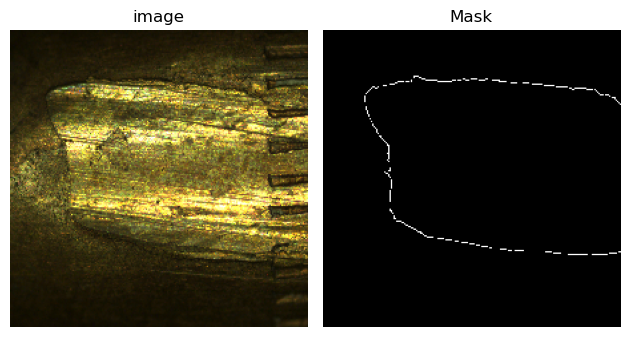

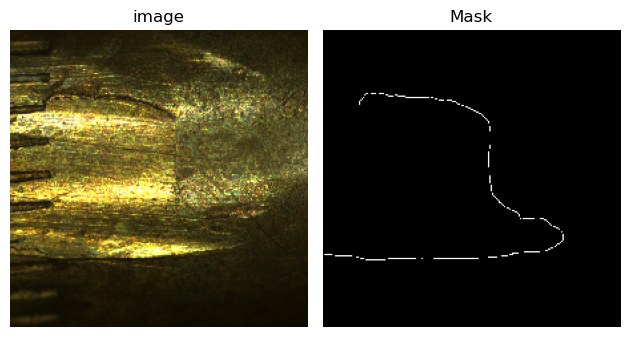

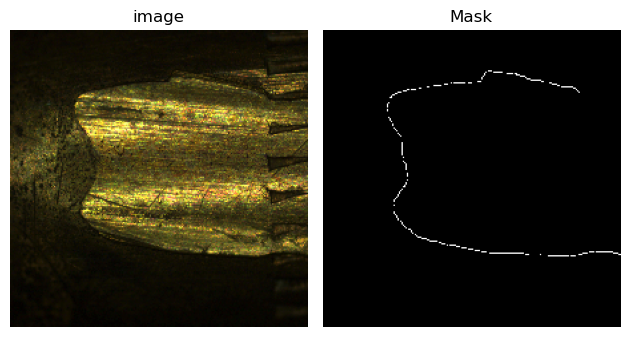

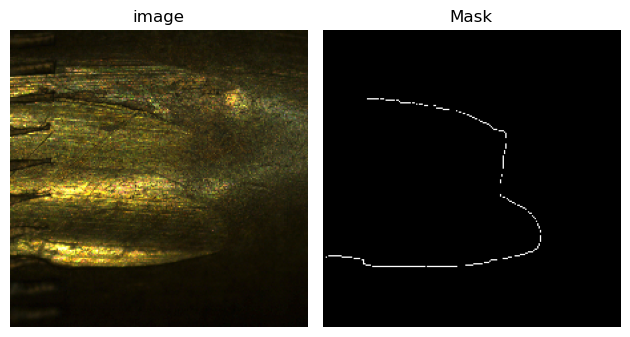

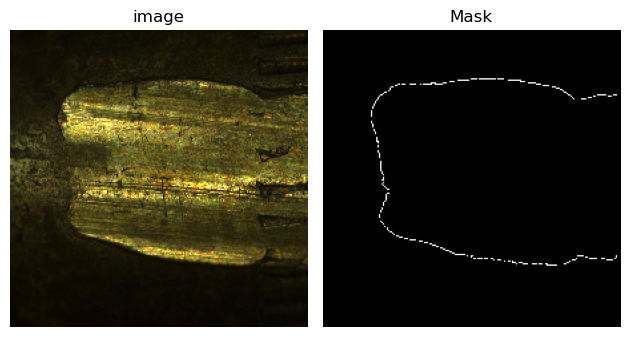

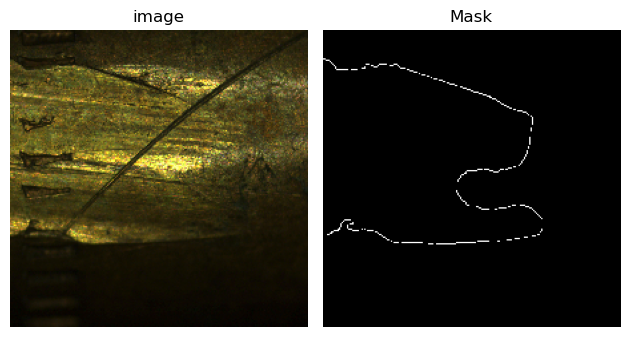

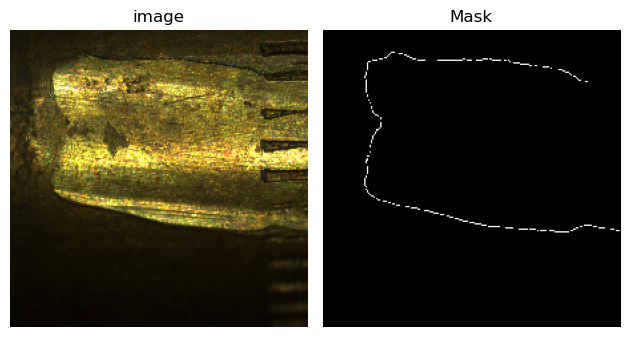

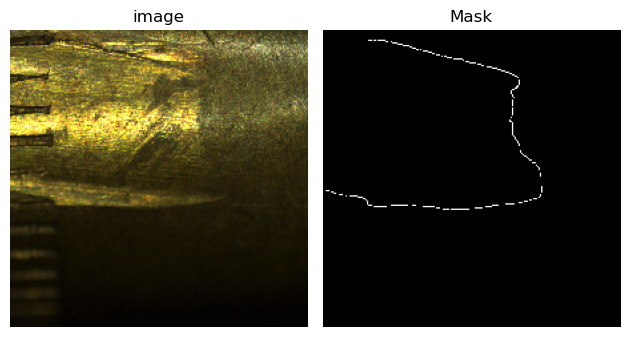

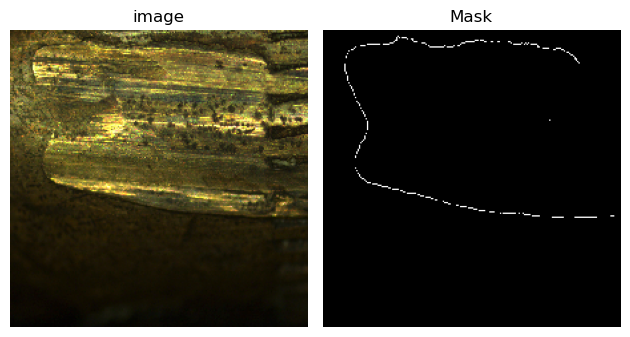

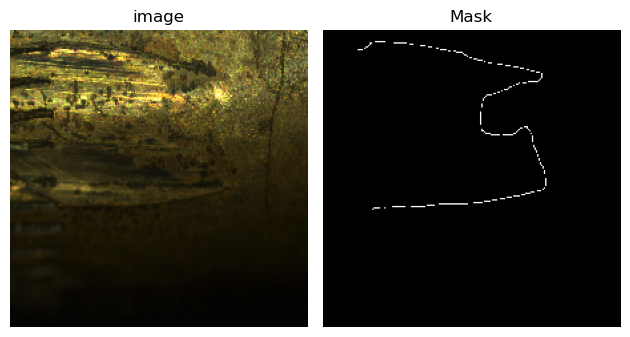

In [64]:
visualization(X,Y)

In [66]:
X = np.asarray(X)
Y = np.asarray(Y)

print(f"the shape of X is {X.shape}")
print(f"the shape of Y is {Y.shape}")

the shape of X is (142, 224, 224, 3)
the shape of Y is (142, 224, 224)


In [10]:
print(Y[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [68]:
Y = np.expand_dims(Y, axis =3)

In [70]:
x_train, x_test, y_train,y_test = train_test_split(X,Y,test_size = 0.1, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split (x_train,y_train,test_size = 0.08, random_state = 42)

In [72]:
print('Train shape:',x_train.shape,y_train.shape)
print('Test_shape:' , x_test.shape,y_test.shape)

Train shape: (116, 224, 224, 3) (116, 224, 224, 1)
Test_shape: (15, 224, 224, 3) (15, 224, 224, 1)


In [74]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Expanding path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv9)
    return model


In [76]:
import tensorflow as tf

Input_shape = (224, 224, 3)
number_of_class = 1

LR = 0.001
EPOCHS = 30
L = tf.keras.losses.BinaryCrossentropy()
optm = tf.keras.optimizers.Adam(LR)

model = unet(Input_shape, number_of_class)

model.summary()

model.compile(optimizer=optm, loss=L, metrics=['accuracy'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_7[0][0], 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = model.fit(x_train, y_train, epochs = 15, batch_size = 8, validation_data = (x_val, y_val))

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step - accuracy: 0.7923 - loss: 0.3484 - val_accuracy: 0.9940 - val_loss: 0.0542
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 135s 9s/step - accuracy: 0.9939 - loss: 0.0588 - val_accuracy: 0.9940 - val_loss: 0.0449
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 136s 9s/step - accuracy: 0.9938 - loss: 0.0470 - val_accuracy: 0.9940 - val_loss: 0.0384
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 149s 10s/step - accuracy: 0.9940 - loss: 0.0374 - val_accuracy: 0.9940 - val_loss: 0.0375
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.9938 - loss: 0.0376 - val_accuracy: 0.9940 - val_loss: 0.0379
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 153s 10s/step - accuracy: 0.9937 - loss: 0.0378 - val_accuracy: 0.9940 - val_loss: 0.0361
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.9938 - loss: 0.0357 - val_accuracy: 0.9940 - val_loss: 0.0347
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.9941 - loss: 0.0331 - val_accuracy: 0.994

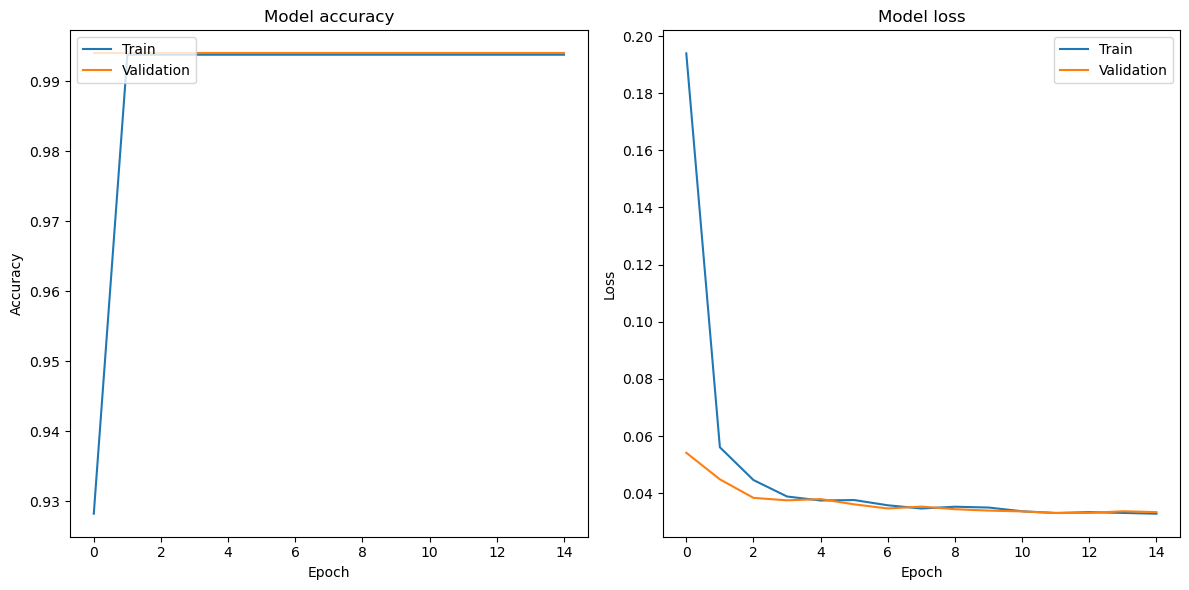

In [80]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train','Validation'], loc = 'upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'], loc = 'upper right')

plt.tight_layout()
plt.show()

In [82]:
def visualization_pred(img, mask_arr):
    for i, value in enumerate(img):

        image = np.expand_dims(img[i], axis=0)
        pred_mask = model.predict(image)
        pr_mask = pred_mask.squeeze()
        threshold = 0.5
        pr_mask = pr_mask > threshold

        fig, axes = plt.subplots(1, 3)
        axes[0].imshow(img[i])
        axes[0].set_title("Image")

        axes[1].imshow(pr_mask, cmap="gray")
        axes[1].set_title("Predicted Mask")

        axes[2].imshow(mask_arr[i], cmap="gray")
        axes[2].set_title("GT Mask")

        # Hide axis for all subplots
        for ax in axes:
            ax.axis('off')

        # Adjust layout to prevent overlap of titles
        plt.tight_layout()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


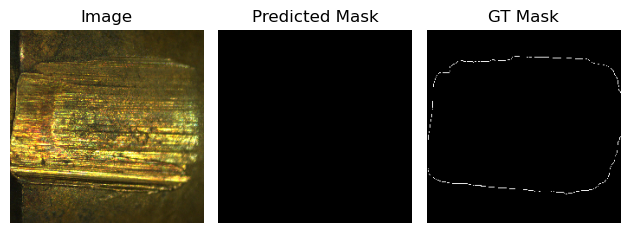

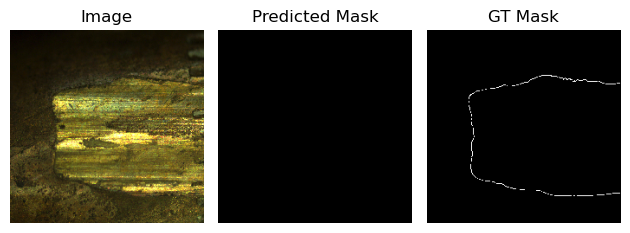

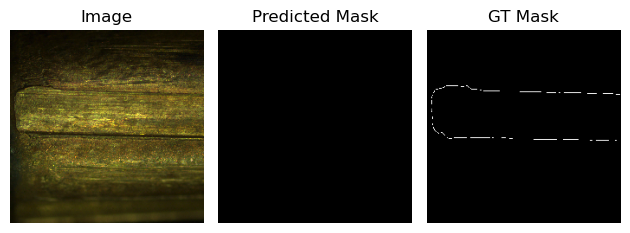

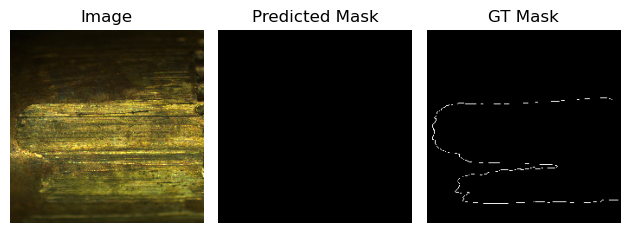

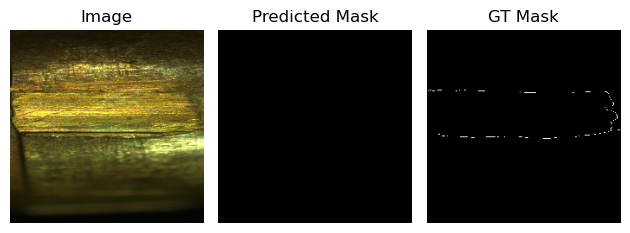

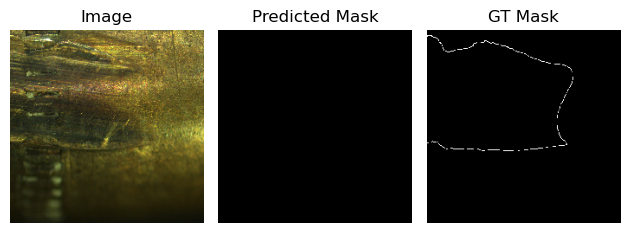

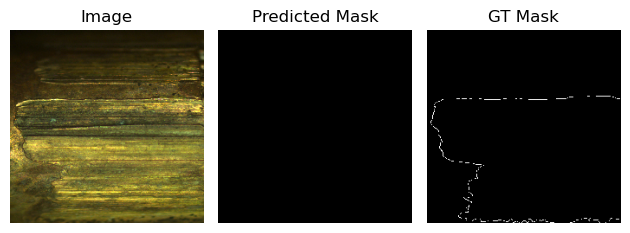

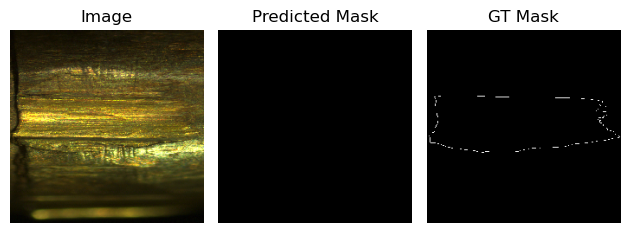

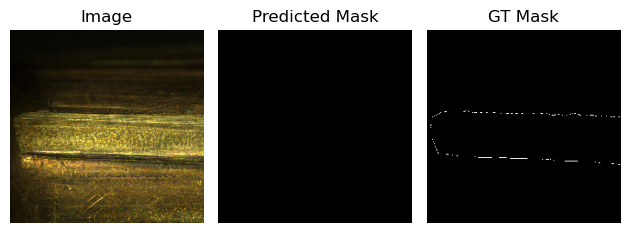

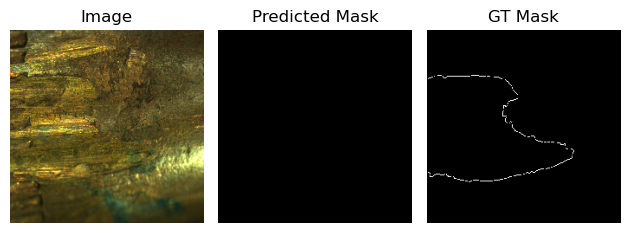

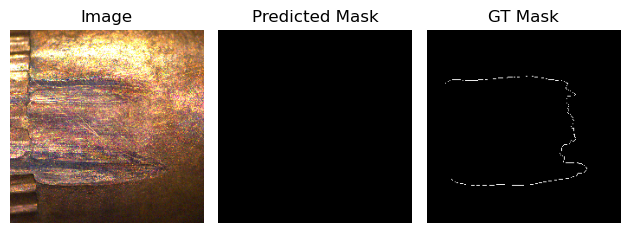

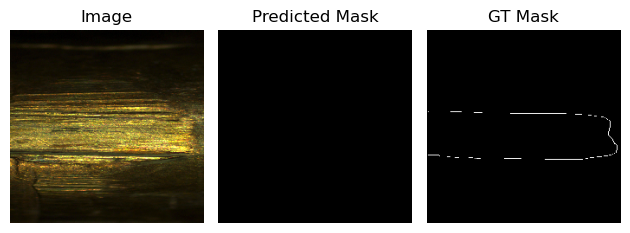

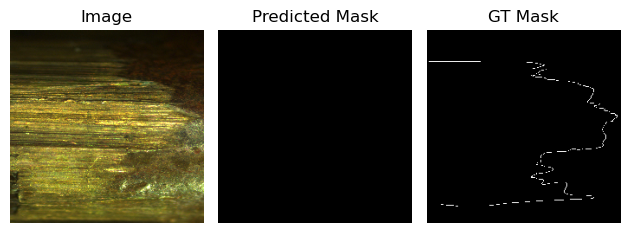

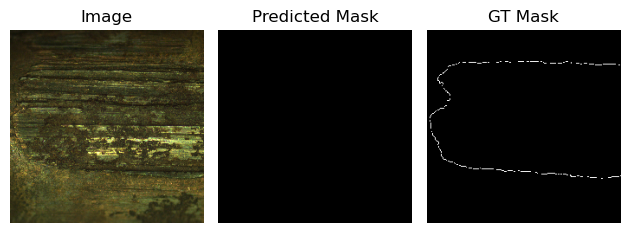

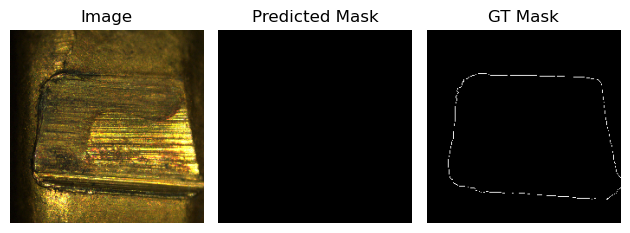

In [84]:
visualization_pred(x_test,y_test)